In this Notebook we are aiming to find clusters of accidents events causing personal injury in Frankfurt am Main. 

As a first step we are loading in all packages and our preprocessed data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import fetch_data as fd
import geopandas as gpd
import matplotlib.patheffects as pe
import contextily
import sklearn as sk

from fetch_data import fetch_traffic_data
from fetch_data import get_city_info
fetch_traffic_data()
get_city_info()

Already have 2016.csv, skipping...
Already have 2017.csv, skipping...
Already have 2018.csv, skipping...
Already have 2019.csv, skipping...
Already have 2020.csv, skipping...
Already have 2021.csv, skipping...
Already have 2022.csv, skipping...
Already have 2023.csv, skipping...
Already have 2024.csv, skipping...


regional key               city   sq km  population
0        11000000             Berlin  891.12     3685265
1        02000000            Hamburg  755.09     1862565
2        09162000            München  310.70     1505005
3        05315000               Köln  405.02     1024621
4        06412000  Frankfurt am Main  248.31      756021
...           ...                ...     ...         ...
2054     16075127         Ziegenrück    8.25         626
2055     16071061            Neumark    8.67         462
2056     16069052         Ummerstadt   15.73         455
2057     03354021      Schnackenburg   23.70         447
2058     01059002              Arnis    0.45         251

[2059 rows x 4 columns]

In [2]:
YEARS = [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
df_dict = fd.get_dfs(YEARS)
df = pd.concat(df_dict.values())
city_info = fd.get_city_info()

# Create Frankfurt specific Dataframe
Frankfurt = df[df["Community_key"] == "06412000"]
Frankfurt.shape
Frankfurt.groupby("UKATEGORIE").size()

# Rename vlaues in UTYP for easier analysis
accident_map = {
    1: "Driving accident",
    2: "Accident caused by turning off the road",
    3: "Accident caused by turning into a road or by crossing it",
    4: "Accident caused by crossing the road",
    5: "Accident involving stationary",
    6: "Accident between vehicles moving along in carriageway",
    7: "Other accident"
}

Frankfurt.loc[:, 'UTYP1'] = Frankfurt['UTYP1'].map(accident_map)
Frankfurt.head()

C:\Users\Adria\AppData\Local\Temp\ipykernel_23052\1605333988.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Driving accident'
 'Accident between vehicles moving along in carriageway'
 'Accident caused by turning into a road or by crossing it' ...
 'Accident between vehicles moving along in carriageway'
 'Accident caused by turning into a road or by crossing it'
 'Accident between vehicles moving along in carriageway']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Frankfurt.loc[:, 'UTYP1'] = Frankfurt['UTYP1'].map(accident_map)


OID_ ULAND UREGBEZ UKREIS UGEMEINDE  UJAHR  UMONAT  USTUNDE  UWOCHENTAG  \
8575  8576    06       4     12       000   2016       1       19           7   
8664  8665    06       4     12       000   2016       1        0           1   
8978  8979    06       4     12       000   2016       1       15           7   
9024  9025    06       4     12       000   2016       1        2           1   
9074  9075    06       4     12       000   2016       1        3           6   

      UKATEGORIE  ...  IstFuss IstKrad  IstGkfz  IstSonstige      LINREFX  \
8575           3  ...        0       0      0.0            0  471854.4512   
8664           3  ...        0       0      0.0            0  465949.1018   
8978           1  ...        0       0      0.0            0  467209.1346   
9024           2  ...        0       0      0.0            0  475327.1534   
9074           3  ...        0       0      0.0            0  477911.2036   

           LINREFY  XGCSWGS84  YGCSWGS84  Community_key        UID  
8575  5.545148e+06   8.606800  50.057949       06412000  2016_8576  
8664  5.551119e+06   8.523772  50.111344       06412000  2016_8665  
8978  5.550947e+06   8.541409  50.109870       06412000  2016_8979  
9024  5.547310e+06   8.655174  50.077547       06412000  2016_9025  
9074  5.548912e+06   8.691196  50.092058       06412000  2016_9075  

[5 rows x 26 columns]

As a first step we will try to get a rough Overview about the distribution of accidents events across the city. 
We can see that the accident spread across the entire city, with the highest concentration of accidents being close to it's center.
This is about what one would expect, so to get actual insights we need to dig deeper.

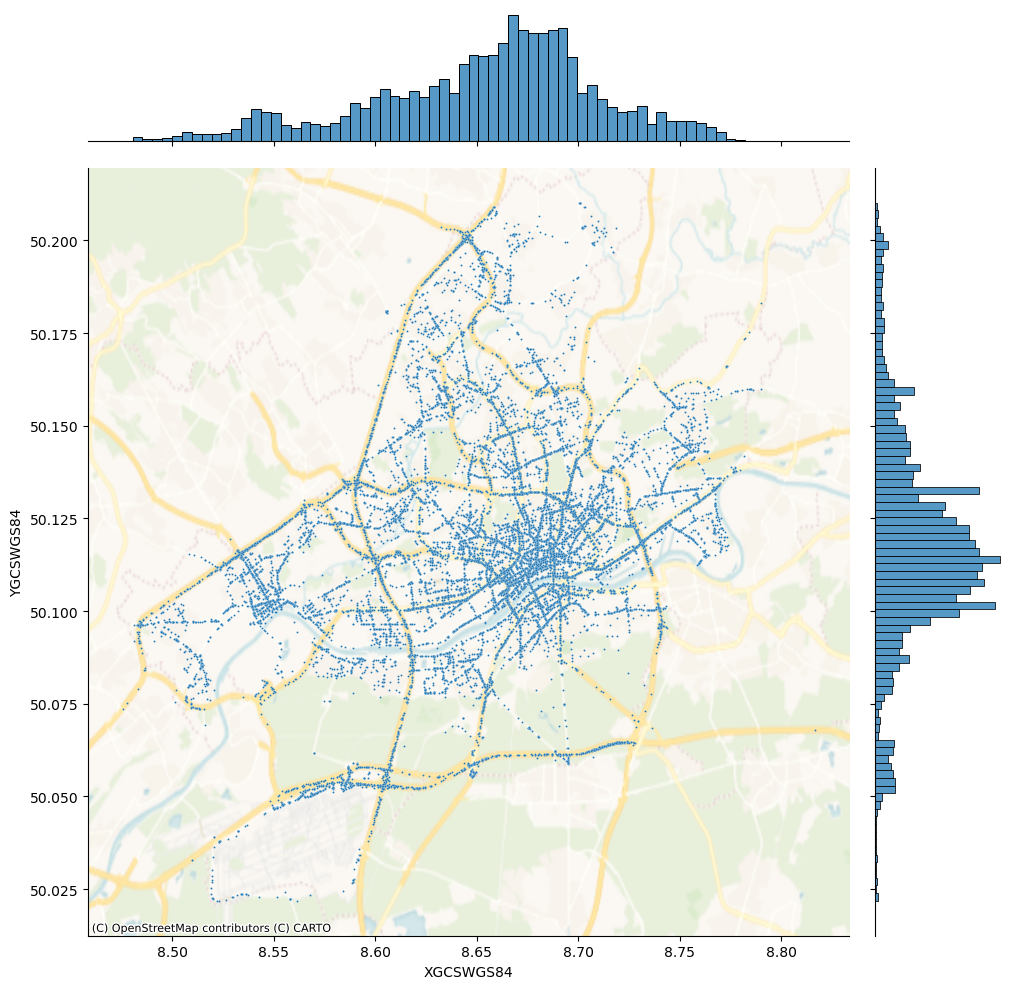

In [53]:
# Generate scatter plot
joint_axes = sns.jointplot(
    x="XGCSWGS84", y="YGCSWGS84", data=Frankfurt, s=2, height=10
)
contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.VoyagerNoLabels,
);

As the next step, we are checking accident distribution across the city by creating weighted center points. For our Accident data, we calculate the mean location of accidents, and then compare those against the Geographical and Physical Center of Frankufrt. From the results we can see that the Mean accident Centers with Bicycle, Pedestrian, and Car involvement are closer to the Frankfurt city center then the Geographical Center points. Since that in itself is not to insightful either, we will need to deploy a clustering alogorithm to get some deeper insights.

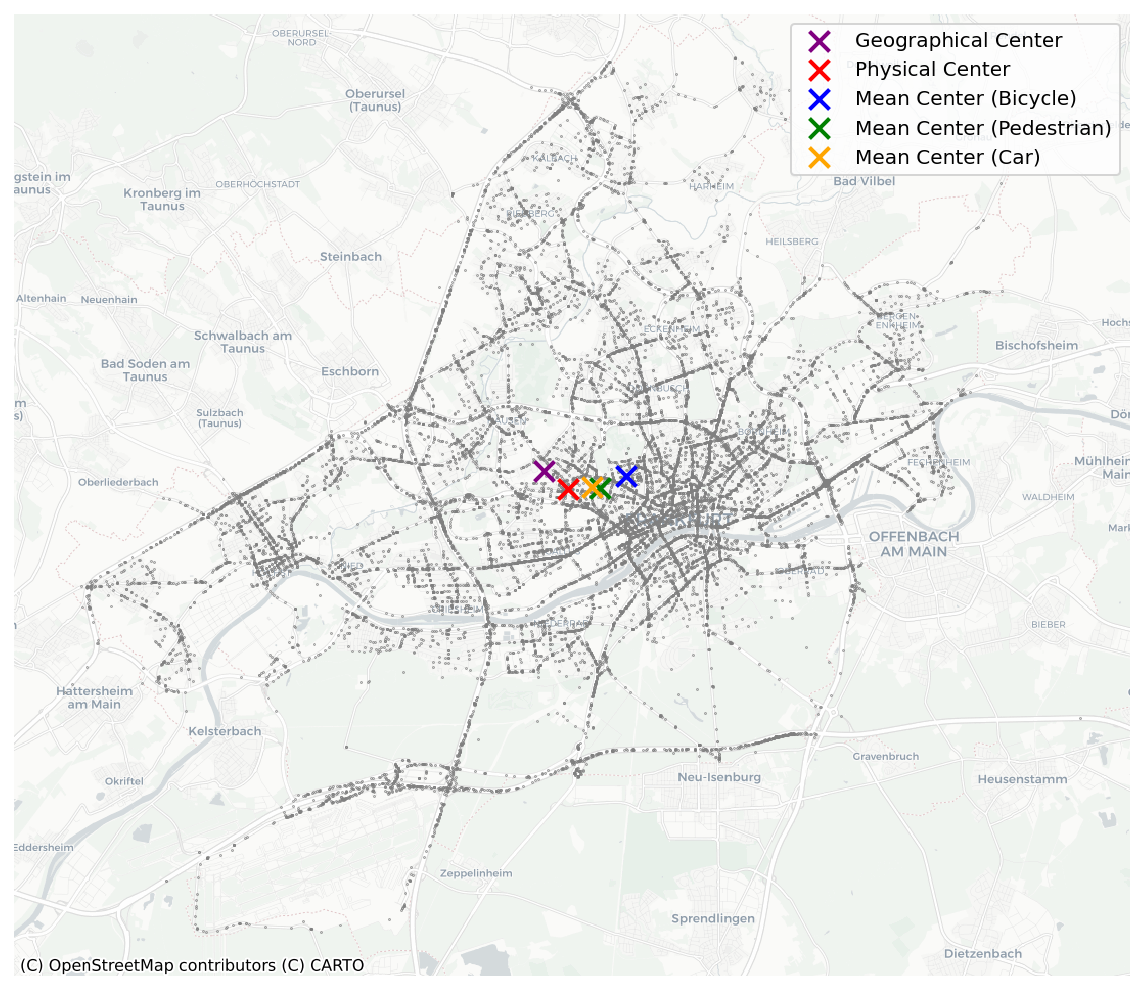

In [4]:
from shapely.geometry import Point

def plot_mean_center(ax, base_gdf, filter_col, color, label):
    """
    Calculates and plots the mean center for a filtered subset of the GeoDataFrame.
    """
    # Filter DataFrame for the specific participant and get mean
    filtered_gdf = base_gdf.loc[base_gdf[filter_col] == 1].copy()
    mean_lon = filtered_gdf['XGCSWGS84'].mean()
    mean_lat = filtered_gdf['YGCSWGS84'].mean()

    # Create a Point and GeoDataFrame
    mean_center_latlon = Point(mean_lon, mean_lat)
    mean_center_gdf = gpd.GeoDataFrame(geometry=[mean_center_latlon], crs="EPSG:4326")

    # Reproject to Mercator
    mean_center_gdf_wm = mean_center_gdf.to_crs(epsg=3857)

    # Plot the mean center
    mean_center_gdf_wm.plot(
        ax=ax,
        marker='x',
        color=color,
        markersize=100,
        linewidths=2, 
        label=label
    )


# 1. Load ALL accident data
gdf_all = gpd.GeoDataFrame(
    Frankfurt,
    geometry=gpd.points_from_xy(Frankfurt.XGCSWGS84, Frankfurt.YGCSWGS84),
    crs="EPSG:4326"  # Tell it the coordinates are Lat/Lon
)

# Reproject all data
gdf_all_wm = gdf_all.to_crs(epsg=3857)

# --- Setup the Plot ---
fig, ax = plt.subplots(figsize=(10, 10), dpi=144)

# 2. Plot ALL accidents first
gdf_all_wm.plot(ax=ax, markersize=0.1, color='gray', alpha=1)

# --- Plot Predefined Centers ---
# Geographical Center
point1_latlon = Point(8.636583, 50.121250)
point1_gdf = gpd.GeoDataFrame(geometry=[point1_latlon], crs="EPSG:4326")
point1_gdf_wm = point1_gdf.to_crs(epsg=3857)
point1_gdf_wm.plot(
    ax=ax,
    marker='x', 
    color='Purple',
    markersize=100,
    linewidths=2,  # <-- CORRECTED ARGUMENT
    label="Geographical Center"
)

# Physical Center
point2_latlon = Point(8.644417, 50.117306)
point2_gdf = gpd.GeoDataFrame(geometry=[point2_latlon], crs="EPSG:4326")
point2_gdf_wm = point2_gdf.to_crs(epsg=3857)
point2_gdf_wm.plot(
    ax=ax,
    marker='x', 
    color='red',
    markersize=100,
    linewidths=2,  # <-- CORRECTED ARGUMENT
    label="Physical Center"
)

# --- 3. Plot Mean Centers for Different Participants ---
plot_mean_center(
    ax, 
    gdf_all, 
    'IstRad', 
    'blue', 
    'Mean Center (Bicycle)'
)

plot_mean_center(
    ax, 
    gdf_all, 
    'IstFuss', 
    'green', 
    'Mean Center (Pedestrian)'
)

plot_mean_center(
    ax, 
    gdf_all, 
    'IstPKW', 
    'orange', 
    'Mean Center (Car)'
)

# --- Add Basemap and Finalize ---
contextily.add_basemap(
    ax,
    crs=gdf_all_wm.crs,
    source=contextily.providers.CartoDB.Positron,
    zoom=12,
    interpolation='None'
)

ax.set_axis_off()
ax.legend()
plt.show()

# DBSCAN 
For this analysis, we are choosing to use the DBSCAN (Density-Based Spatial Clustering of Applications with Noise) algorithm.
There are many potential Clustering algorithms that could be used on this dataset, but we chose DBSCAN specifically due to its favorable attributes for our analysis:
1. DBSCAN is a density-based algorithm, meaning it's specifically designed to find regions where points are packed closely together, which lines up with our goal
2. Accident hotspots comes in all kinds of shapes. A hotspot might follow a winding section of a highway, or form a "T" shape at a dangerous intersection. DBSCAN does not assume any        shapes, which lines up with our use-case.
3. For our analysis, we want to find systemic hotspots, and want to seperate them from random incidents. As DBSCAN allows for noise, it will exclude isolated points from our clusters rather then associate them with a cluster


To get started, we need to choose our input for the two main parameters that can be tuned with DBSCAN: Eps (ε) and and the minimum samples.
Since we have no good knowledge about which numbers could be appropriate, and one way of getting a good estimate is to use an Elbow curve with the sklearn NearestNeighbors alogirthm.

When we choose k = 20 as a starting point, and get the below curve. The result shows us that we can expect get a good clustering result if we choose ε to be between 350-400.
In our case though, we will use a slightly different approach. We assume that two accident events are related if they are within 100 meters of each other. Since we are only looking for the most dense areas, we will set eps = 100 and then scale our minimum samples until 5 or less clusters remain which then get analyzed based on the causes for the accidents.


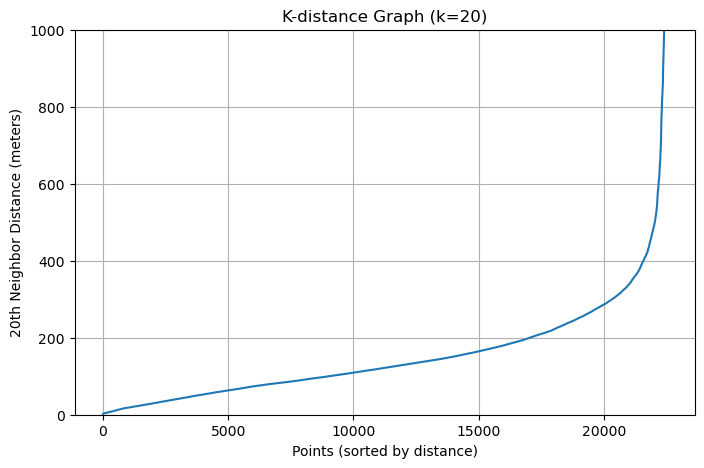

In [17]:
from sklearn.neighbors import NearestNeighbors
data_for_clustering = Frankfurt[["LINREFX", "LINREFY"]]

k = 20
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(data_for_clustering)
distances, indices = neighbors_fit.kneighbors(data_for_clustering)
k_distances = np.sort(distances[:, k-1], axis=0)

plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.title('K-distance Graph (k=20)')
plt.xlabel('Points (sorted by distance)')
plt.ylabel(f'{k}th Neighbor Distance (meters)')
plt.grid(True)
plt.ylim(0, 1000)
plt.show()

First, we are plotting all accident events and see where the main hotspots for accidents of any kind are in Frankfurt. 
We achieve 5 or less clusters for a min samples value of 85, ε is fixed to 100. The result is the below cluster.
We examine Cluster 2 specifically due to it's proximity to our Frankfurt School of Finance and Management.

Found 4 clusters.
Cluster Center Coordinates 
         Latitude  Longitude  \
labels                         
0       50.118726   8.731378   
1       50.148025   8.666328   
2       50.131795   8.683852   
3       50.107326   8.656040   

                                                                           Google_Maps_Link  
labels                                                                                       
0        https://www.google.com/maps/search/?api=1&query=50.11872602334982,8.73137784321529  
1       https://www.google.com/maps/search/?api=1&query=50.14802549700004,8.666327938444482  
2       https://www.google.com/maps/search/?api=1&query=50.13179462461391,8.683851999604004  
3       https://www.google.com/maps/search/?api=1&query=50.10732622077533,8.656040092415775  
Generating Cluster Map 


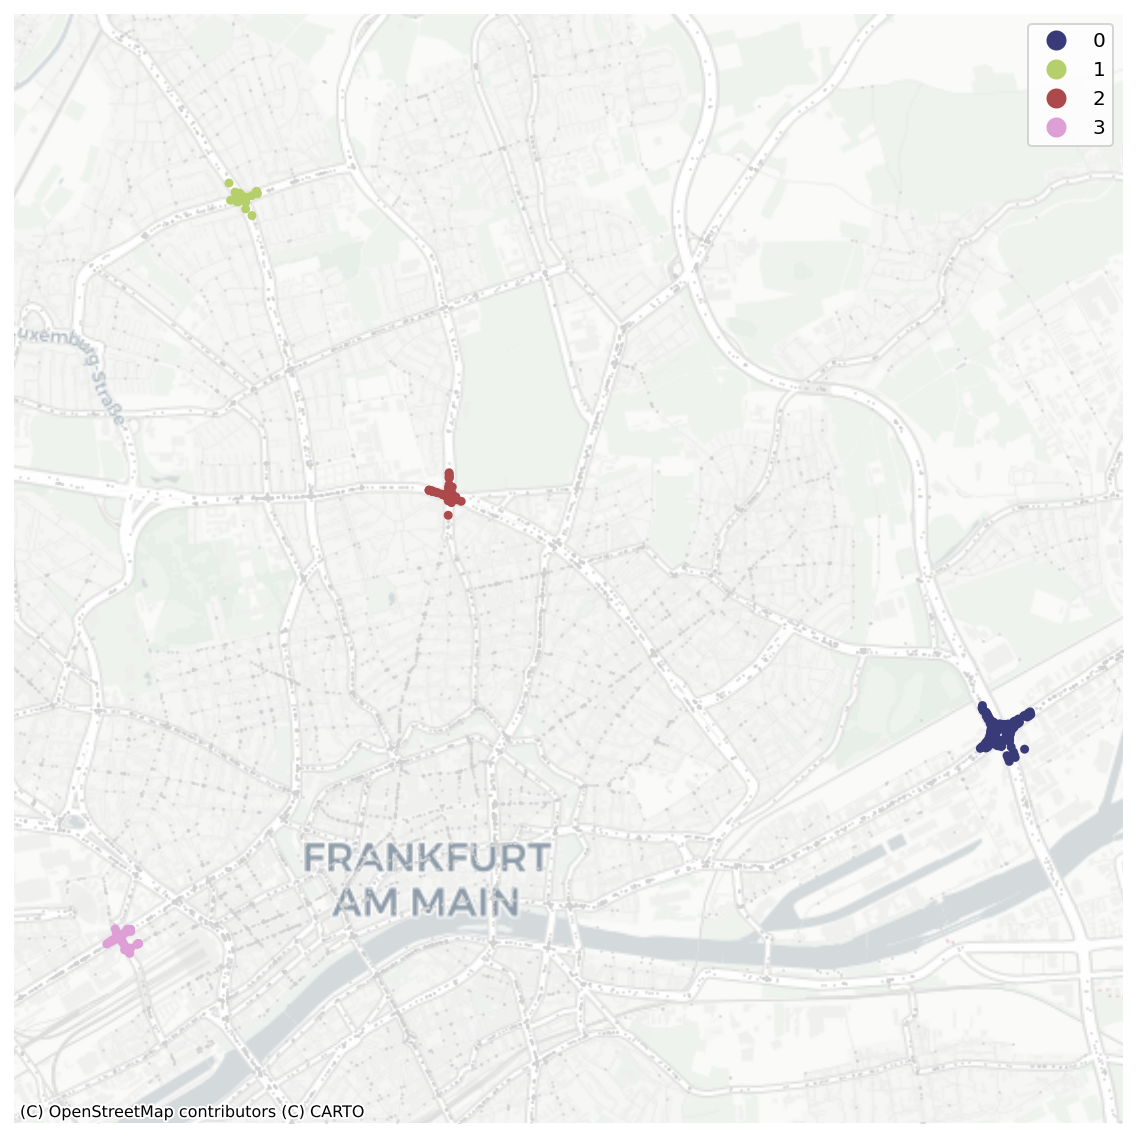

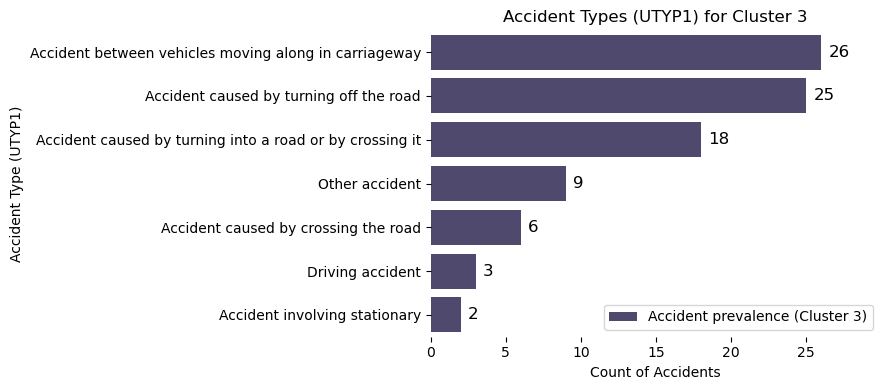

In [56]:
# All Accident events
# DBSCAN parameters
CURRENT_EPS = 100
CURRENT_MIN_SAMPLES = 85

# Analysis parameters
COORDINATE_SYSTEM_GPS = "EPSG:4326"
COORDINATE_SYSTEM_WEB = "EPSG:3857"

# Plotting parameters
CLUSTER_TO_PLOT = 3
MAP_PADDING_FACTOR = 0.1
CHART_COLOR = "#494373"

# This placeholder is necessary for the script to run.
if 'Frankfurt' not in locals():
    print("Error: 'Frankfurt' dataframe not loaded. Please load your data first.")
    # YOU MUST REPLACE THIS:
    Frankfurt = pd.DataFrame() 

# Filter for pedestrians
Frankfurt = Frankfurt

if Frankfurt.empty:
    print("Check Filter")
else:
    # Run DBSCAN
    clusterer = DBSCAN(
        metric='euclidean', 
        eps=CURRENT_EPS,
        min_samples=CURRENT_MIN_SAMPLES
    )
    clusterer.fit(Frankfurt[["LINREFX", "LINREFY"]])
    Frankfurt.loc[:, 'labels'] = clusterer.labels_

    # Cluster Report 
    unique_labels = np.unique(clusterer.labels_)
    num_clusters = len(unique_labels[unique_labels != -1])
    print(f"Found {num_clusters} clusters.")

    # Filter out noise points for all cluster-based analysis
    clusters_df = Frankfurt[Frankfurt['labels'] != -1]

    if clusters_df.empty:
        print("No clusters found (only noise). Map and charts will not be generated.")
    else:
        # Coordinates Report 
        print("Cluster Center Coordinates ")
        cluster_centers = clusters_df.groupby('labels')[['YGCSWGS84', 'XGCSWGS84']].mean()
        cluster_centers.rename(columns={'YGCSWGS84': 'Latitude', 'XGCSWGS84': 'Longitude'}, inplace=True)
        cluster_centers['Google_Maps_Link'] = cluster_centers.apply(
            lambda row: f"https://www.google.com/maps/search/?api=1&query={row['Latitude']},{row['Longitude']}", 
            axis=1
        )
        pd.set_option('display.max_colwidth', None)
        print(cluster_centers)

        # PLOT CLUSTER MAP 
        print("Generating Cluster Map ")
        gdf = gpd.GeoDataFrame(
            Frankfurt, 
            geometry=gpd.points_from_xy(Frankfurt.XGCSWGS84, Frankfurt.YGCSWGS84),
            crs=COORDINATE_SYSTEM_GPS
        )
        gdf_wm = gdf.to_crs(COORDINATE_SYSTEM_WEB)
        fig, ax = plt.subplots(figsize=(10, 10), dpi=144)

        # Plot noise
        gdf_wm[gdf_wm['labels'] == -1].plot(ax=ax, color='lightgrey', markersize=0.5, alpha=0.5, label='Noise')
        
        # Plot clusters
        clusters_wm = gdf_wm[gdf_wm['labels'] != -1]
        clusters_wm.plot(ax=ax, column='labels', categorical=True, markersize=12, legend=True, cmap='tab20b')
        
        # Zoom to clusters
        minx, miny, maxx, maxy = clusters_wm.total_bounds
        center_x, center_y = (minx + maxx) / 2, (miny + maxy) / 2
        data_width, data_height = maxx - minx, maxy - miny
        desired_range = max(data_width, data_height) * (1 + 2 * MAP_PADDING_FACTOR)
        if desired_range == 0: desired_range = 1000 # 1km default
        
        half_range = desired_range / 2
        ax.set_xlim(center_x - half_range, center_x + half_range)
        ax.set_ylim(center_y - half_range, center_y + half_range)

        contextily.add_basemap(ax, source=contextily.providers.CartoDB.Positron)
        ax.set_axis_off()
        plt.show()

        # Plot bar chart for Cluster
        cluster_to_analyze = clusters_df[clusters_df['labels'] == CLUSTER_TO_PLOT]

        if cluster_to_analyze.empty:
            print(f"Error: Cluster {CLUSTER_TO_PLOT} not found or is empty.")
            print(f"Available clusters are: {list(clusters_df['labels'].unique())}")
        else:
            # Create the DataFrame with counts
            plot_df = cluster_to_analyze['UTYP1'].value_counts().reset_index()
            plot_df.columns = ['UTYP1', 'count']
            plot_df['UTYP1'] = plot_df['UTYP1'].astype(str)
            plot_df = plot_df.sort_values("count", ascending=False)

            # Plotting
            fig_bar, ax_bar = plt.subplots(figsize=(9, 4))
            sns.barplot(
                x="count", 
                y="UTYP1", 
                data=plot_df,
                orient='h',
                label=f"Accident prevalence (Cluster {CLUSTER_TO_PLOT})", 
                color=CHART_COLOR,
                ax=ax_bar
            )

            # labels and styling
            ax_bar.bar_label(ax_bar.containers[0], fmt='%.0f', padding=5, fontsize=12)
            max_val = plot_df['count'].max()
            ax_bar.set(xlim=(0, max_val * 1.15))
            ax_bar.set_title(f"Accident Types (UTYP1) for Cluster {CLUSTER_TO_PLOT}")
            ax_bar.set_xlabel("Count of Accidents")
            ax_bar.set_ylabel("Accident Type (UTYP1)")
            ax_bar.legend(loc="lower right", frameon=True)
            sns.despine(ax=ax_bar, left=True, bottom=True)
            plt.grid(False)
            plt.tight_layout()
            plt.show()

In the next step, we are filtering the dataset to accidents that include bicycles. This does not exclude Pedestrians or Cars from the accidents, but makes sure every accident involves a cyclist. We keep ε fixed to 100, and achieve 5 Clusters for minimum samples = 40.

We are fetching the reasons for accidents in Cluster 3 due to its location next to the river.
We can see that the vast majority of accidents are caused by turning off the road, which means that cyclists are likely hit by cars when they leave the street for another direction.
The location can be inspected through the provided google maps link.

Found 5 clusters.
Cluster Center Coordinates 
         Latitude  Longitude  \
labels                         
0       50.131888   8.683750   
1       50.132667   8.695200   
2       50.109310   8.694488   
3       50.107707   8.675633   
4       50.114837   8.670445   

                                                                            Google_Maps_Link  
labels                                                                                        
0       https://www.google.com/maps/search/?api=1&query=50.131887668760044,8.683750031440045  
1        https://www.google.com/maps/search/?api=1&query=50.13266749806784,8.695199520271231  
2        https://www.google.com/maps/search/?api=1&query=50.10931003965222,8.694488326195692  
3        https://www.google.com/maps/search/?api=1&query=50.10770682661707,8.675633276106428  
4       https://www.google.com/maps/search/?api=1&query=50.114836522707364,8.670444865634185  
Generating Cluster Map 


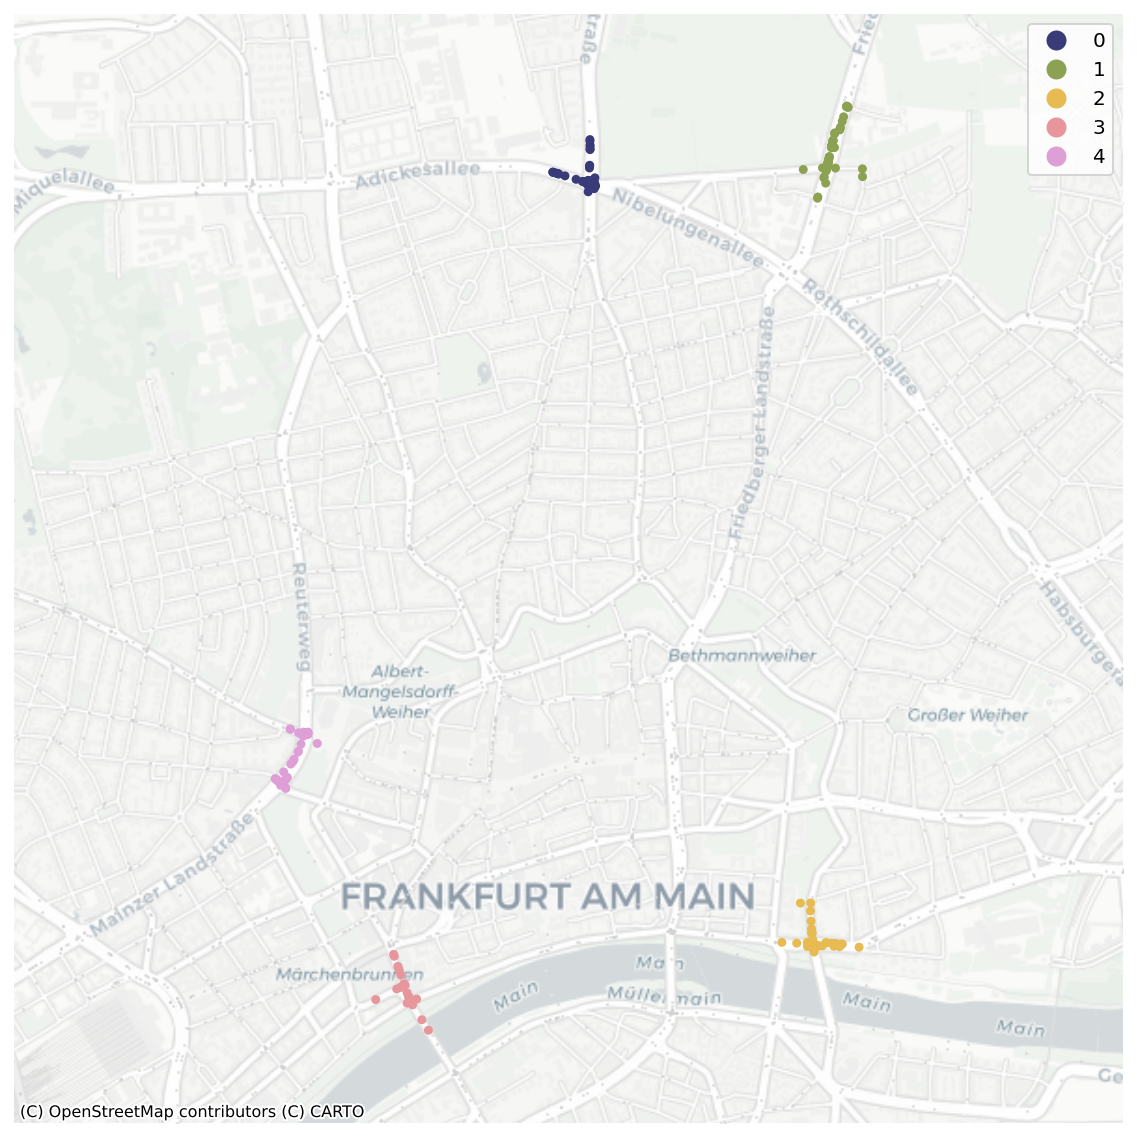

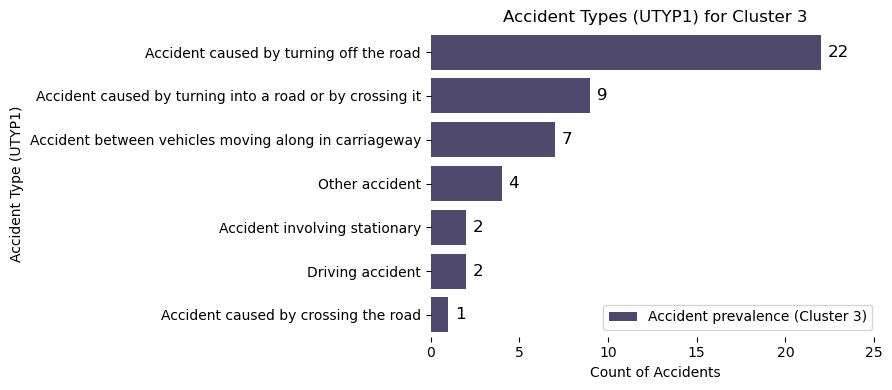

In [57]:
# Bicycle Clusters
# DBSCAN parameters
CURRENT_EPS = 100
CURRENT_MIN_SAMPLES = 40

# Analysis parameters
COORDINATE_SYSTEM_GPS = "EPSG:4326"
COORDINATE_SYSTEM_WEB = "EPSG:3857"

# Plotting parameters
CLUSTER_TO_PLOT = 3
MAP_PADDING_FACTOR = 0.1
CHART_COLOR = "#494373"

# This placeholder is necessary for the script to run.
if 'Frankfurt' not in locals():
    print("Error: 'Frankfurt' dataframe not loaded. Please load your data first.")
    # YOU MUST REPLACE THIS:
    Frankfurt = pd.DataFrame() 

# Filter for pedestrians
Frankfurt_Bicycle = Frankfurt[Frankfurt['IstRad'] == 1].copy()

if Frankfurt_Bicycle.empty:
    print("Check Filter")
else:
    # Run DBSCAN
    clusterer = DBSCAN(
        metric='euclidean', 
        eps=CURRENT_EPS,
        min_samples=CURRENT_MIN_SAMPLES
    )
    clusterer.fit(Frankfurt_Bicycle[["LINREFX", "LINREFY"]])
    Frankfurt_Bicycle.loc[:, 'labels'] = clusterer.labels_

    # Cluster Report 
    unique_labels = np.unique(clusterer.labels_)
    num_clusters = len(unique_labels[unique_labels != -1])
    print(f"Found {num_clusters} clusters.")

    # Filter out noise points for all cluster-based analysis
    clusters_df = Frankfurt_Bicycle[Frankfurt_Bicycle['labels'] != -1]

    if clusters_df.empty:
        print("No clusters found (only noise). Map and charts will not be generated.")
    else:
        # Coordinates Report 
        print("Cluster Center Coordinates ")
        cluster_centers = clusters_df.groupby('labels')[['YGCSWGS84', 'XGCSWGS84']].mean()
        cluster_centers.rename(columns={'YGCSWGS84': 'Latitude', 'XGCSWGS84': 'Longitude'}, inplace=True)
        cluster_centers['Google_Maps_Link'] = cluster_centers.apply(
            lambda row: f"https://www.google.com/maps/search/?api=1&query={row['Latitude']},{row['Longitude']}", 
            axis=1
        )
        pd.set_option('display.max_colwidth', None)
        print(cluster_centers)

        # PLOT CLUSTER MAP 
        print("Generating Cluster Map ")
        gdf = gpd.GeoDataFrame(
            Frankfurt_Bicycle, 
            geometry=gpd.points_from_xy(Frankfurt_Bicycle.XGCSWGS84, Frankfurt_Bicycle.YGCSWGS84),
            crs=COORDINATE_SYSTEM_GPS
        )
        gdf_wm = gdf.to_crs(COORDINATE_SYSTEM_WEB)
        fig, ax = plt.subplots(figsize=(10, 10), dpi=144)

        # Plot noise
        gdf_wm[gdf_wm['labels'] == -1].plot(ax=ax, color='lightgrey', markersize=0.5, alpha=0.5, label='Noise')
        
        # Plot clusters
        clusters_wm = gdf_wm[gdf_wm['labels'] != -1]
        clusters_wm.plot(ax=ax, column='labels', categorical=True, markersize=12, legend=True, cmap='tab20b')
        
        # Zoom to clusters
        minx, miny, maxx, maxy = clusters_wm.total_bounds
        center_x, center_y = (minx + maxx) / 2, (miny + maxy) / 2
        data_width, data_height = maxx - minx, maxy - miny
        desired_range = max(data_width, data_height) * (1 + 2 * MAP_PADDING_FACTOR)
        if desired_range == 0: desired_range = 1000 # 1km default
        
        half_range = desired_range / 2
        ax.set_xlim(center_x - half_range, center_x + half_range)
        ax.set_ylim(center_y - half_range, center_y + half_range)

        contextily.add_basemap(ax, source=contextily.providers.CartoDB.Positron)
        ax.set_axis_off()
        plt.show()

        # Plot bar chart for Cluster
        cluster_to_analyze = clusters_df[clusters_df['labels'] == CLUSTER_TO_PLOT]

        if cluster_to_analyze.empty:
            print(f"Error: Cluster {CLUSTER_TO_PLOT} not found or is empty.")
            print(f"Available clusters are: {list(clusters_df['labels'].unique())}")
        else:
            # Create the DataFrame with counts
            plot_df = cluster_to_analyze['UTYP1'].value_counts().reset_index()
            plot_df.columns = ['UTYP1', 'count']
            plot_df['UTYP1'] = plot_df['UTYP1'].astype(str)
            plot_df = plot_df.sort_values("count", ascending=False)

            # Plotting
            fig_bar, ax_bar = plt.subplots(figsize=(9, 4))
            sns.barplot(
                x="count", 
                y="UTYP1", 
                data=plot_df,
                orient='h',
                label=f"Accident prevalence (Cluster {CLUSTER_TO_PLOT})", 
                color=CHART_COLOR,
                ax=ax_bar
            )

            # labels and styling
            ax_bar.bar_label(ax_bar.containers[0], fmt='%.0f', padding=5, fontsize=12)
            max_val = plot_df['count'].max()
            ax_bar.set(xlim=(0, max_val * 1.15))
            ax_bar.set_title(f"Accident Types (UTYP1) for Cluster {CLUSTER_TO_PLOT}")
            ax_bar.set_xlabel("Count of Accidents")
            ax_bar.set_ylabel("Accident Type (UTYP1)")
            ax_bar.legend(loc="lower right", frameon=True)
            sns.despine(ax=ax_bar, left=True, bottom=True)
            plt.grid(False)
            plt.tight_layout()
            plt.show()

In the next step, we are filtering the dataset to accidents that include pedestrians. We keep ε fixed to 100, and achieve 5 Clusters for minimum samples = 20. the low amount of minimum samples is needed due to the prevelance of pedestrians is rather low.

We are fetching the reasons for accidents in Cluster 1, as its location seems unintuative.

Found 5 clusters.
Cluster Center Coordinates 
         Latitude  Longitude  \
labels                         
0       50.107623   8.665251   
1       50.127003   8.692066   
2       50.114260   8.687714   
3       50.109289   8.665735   
4       50.123177   8.701829   

                                                                            Google_Maps_Link  
labels                                                                                        
0        https://www.google.com/maps/search/?api=1&query=50.10762310240005,8.665250677780044  
1         https://www.google.com/maps/search/?api=1&query=50.12700253795459,8.69206562454549  
2       https://www.google.com/maps/search/?api=1&query=50.114259839911156,8.687714124533379  
3        https://www.google.com/maps/search/?api=1&query=50.10928948112505,8.665734736750046  
4        https://www.google.com/maps/search/?api=1&query=50.123177139500044,8.70182862185003  
Generating Cluster Map 


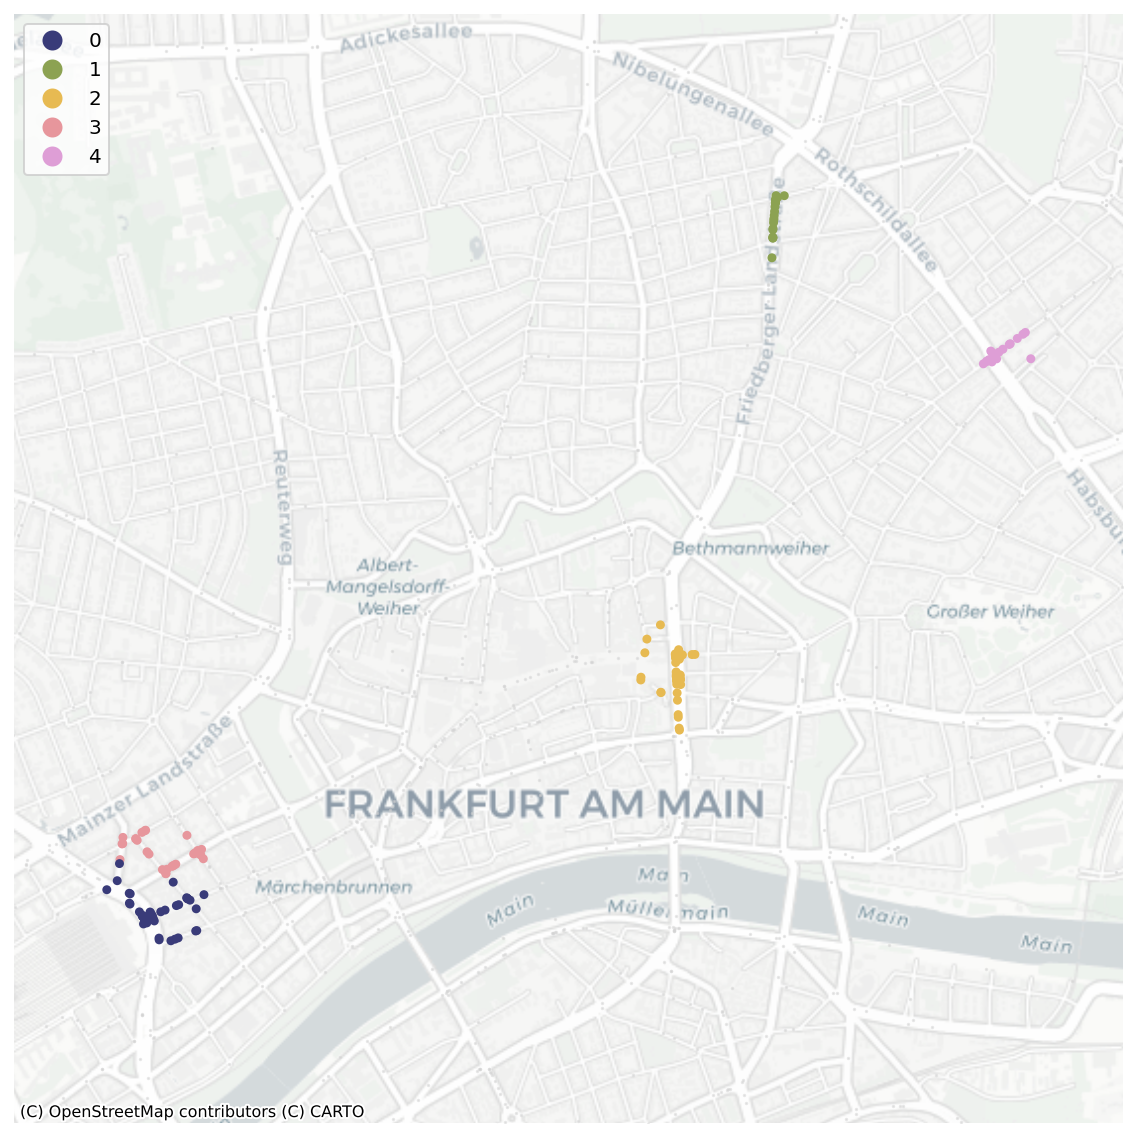

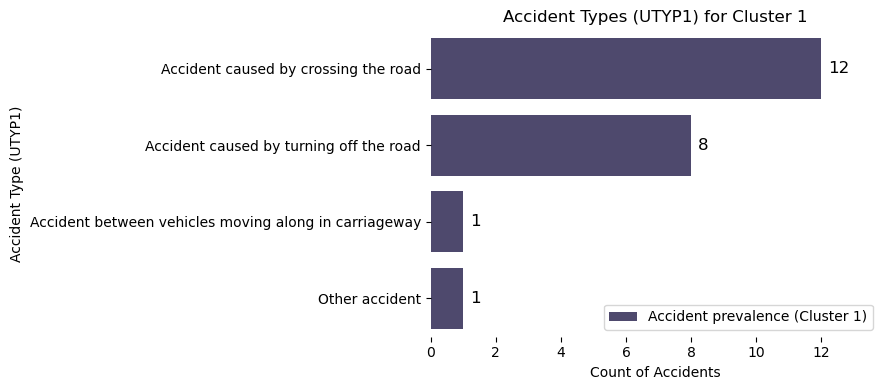

In [58]:
# Pedestrian Clusters
# DBSCAN parameters
CURRENT_EPS = 100
CURRENT_MIN_SAMPLES = 20

# Analysis parameters
COORDINATE_SYSTEM_GPS = "EPSG:4326"
COORDINATE_SYSTEM_WEB = "EPSG:3857"

# Plotting parameters
CLUSTER_TO_PLOT = 1
MAP_PADDING_FACTOR = 0.1
CHART_COLOR = "#494373"

# This placeholder is necessary for the script to run.
if 'Frankfurt' not in locals():
    print("Error: 'Frankfurt' dataframe not loaded. Please load your data first.")
    # YOU MUST REPLACE THIS:
    Frankfurt = pd.DataFrame() 

# Filter for pedestrians
Frankfurt_Pedestrian = Frankfurt[Frankfurt['IstFuss'] == 1].copy()

if Frankfurt_Pedestrian.empty:
    print("Check Filter")
else:
    # Run DBSCAN
    clusterer = DBSCAN(
        metric='euclidean', 
        eps=CURRENT_EPS,
        min_samples=CURRENT_MIN_SAMPLES
    )
    clusterer.fit(Frankfurt_Pedestrian[["LINREFX", "LINREFY"]])
    Frankfurt_Pedestrian.loc[:, 'labels'] = clusterer.labels_

    # Cluster Report 
    unique_labels = np.unique(clusterer.labels_)
    num_clusters = len(unique_labels[unique_labels != -1])
    print(f"Found {num_clusters} clusters.")

    # Filter out noise points for all cluster-based analysis
    clusters_df = Frankfurt_Pedestrian[Frankfurt_Pedestrian['labels'] != -1]

    if clusters_df.empty:
        print("No clusters found (only noise). Map and charts will not be generated.")
    else:
        # Coordinates Report 
        print("Cluster Center Coordinates ")
        cluster_centers = clusters_df.groupby('labels')[['YGCSWGS84', 'XGCSWGS84']].mean()
        cluster_centers.rename(columns={'YGCSWGS84': 'Latitude', 'XGCSWGS84': 'Longitude'}, inplace=True)
        cluster_centers['Google_Maps_Link'] = cluster_centers.apply(
            lambda row: f"https://www.google.com/maps/search/?api=1&query={row['Latitude']},{row['Longitude']}", 
            axis=1
        )
        pd.set_option('display.max_colwidth', None)
        print(cluster_centers)

        # PLOT CLUSTER MAP 
        print("Generating Cluster Map ")
        gdf = gpd.GeoDataFrame(
            Frankfurt_Pedestrian, 
            geometry=gpd.points_from_xy(Frankfurt_Pedestrian.XGCSWGS84, Frankfurt_Pedestrian.YGCSWGS84),
            crs=COORDINATE_SYSTEM_GPS
        )
        gdf_wm = gdf.to_crs(COORDINATE_SYSTEM_WEB)
        fig, ax = plt.subplots(figsize=(10, 10), dpi=144)

        # Plot noise
        gdf_wm[gdf_wm['labels'] == -1].plot(ax=ax, color='lightgrey', markersize=0.5, alpha=0.5, label='Noise')
        
        # Plot clusters
        clusters_wm = gdf_wm[gdf_wm['labels'] != -1]
        clusters_wm.plot(ax=ax, column='labels', categorical=True, markersize=12, legend=True, cmap='tab20b')
        
        # Zoom to clusters
        minx, miny, maxx, maxy = clusters_wm.total_bounds
        center_x, center_y = (minx + maxx) / 2, (miny + maxy) / 2
        data_width, data_height = maxx - minx, maxy - miny
        desired_range = max(data_width, data_height) * (1 + 2 * MAP_PADDING_FACTOR)
        if desired_range == 0: desired_range = 1000 # 1km default
        
        half_range = desired_range / 2
        ax.set_xlim(center_x - half_range, center_x + half_range)
        ax.set_ylim(center_y - half_range, center_y + half_range)

        contextily.add_basemap(ax, source=contextily.providers.CartoDB.Positron)
        ax.set_axis_off()
        plt.show()

        # Plot bar chart for Cluster
        cluster_to_analyze = clusters_df[clusters_df['labels'] == CLUSTER_TO_PLOT]

        if cluster_to_analyze.empty:
            print(f"Error: Cluster {CLUSTER_TO_PLOT} not found or is empty.")
            print(f"Available clusters are: {list(clusters_df['labels'].unique())}")
        else:
            # Create the DataFrame with counts
            plot_df = cluster_to_analyze['UTYP1'].value_counts().reset_index()
            plot_df.columns = ['UTYP1', 'count']
            plot_df['UTYP1'] = plot_df['UTYP1'].astype(str)
            plot_df = plot_df.sort_values("count", ascending=False)

            # Plotting
            fig_bar, ax_bar = plt.subplots(figsize=(9, 4))
            sns.barplot(
                x="count", 
                y="UTYP1", 
                data=plot_df,
                orient='h',
                label=f"Accident prevalence (Cluster {CLUSTER_TO_PLOT})", 
                color=CHART_COLOR,
                ax=ax_bar
            )

            # labels and styling
            ax_bar.bar_label(ax_bar.containers[0], fmt='%.0f', padding=5, fontsize=12)
            max_val = plot_df['count'].max()
            ax_bar.set(xlim=(0, max_val * 1.15))
            ax_bar.set_title(f"Accident Types (UTYP1) for Cluster {CLUSTER_TO_PLOT}")
            ax_bar.set_xlabel("Count of Accidents")
            ax_bar.set_ylabel("Accident Type (UTYP1)")
            ax_bar.legend(loc="lower right", frameon=True)
            sns.despine(ax=ax_bar, left=True, bottom=True)
            plt.grid(False)
            plt.tight_layout()
            plt.show()

We repeat the same process for Nighttime accidents.

Found 5 clusters.
Cluster Center Coordinates 
         Latitude  Longitude  \
labels                         
0       50.118521   8.731182   
1       50.100288   8.667499   
2       50.109652   8.687842   
3       50.107302   8.656143   
4       50.114499   8.687865   

                                                                            Google_Maps_Link  
labels                                                                                        
0       https://www.google.com/maps/search/?api=1&query=50.118520922400045,8.731181789428613  
1       https://www.google.com/maps/search/?api=1&query=50.100287721500045,8.667498990875046  
2        https://www.google.com/maps/search/?api=1&query=50.10965207680005,8.687842489333375  
3        https://www.google.com/maps/search/?api=1&query=50.10730183256006,8.656142532560047  
4        https://www.google.com/maps/search/?api=1&query=50.11449913978383,8.687864541243284  
Generating Cluster Map 


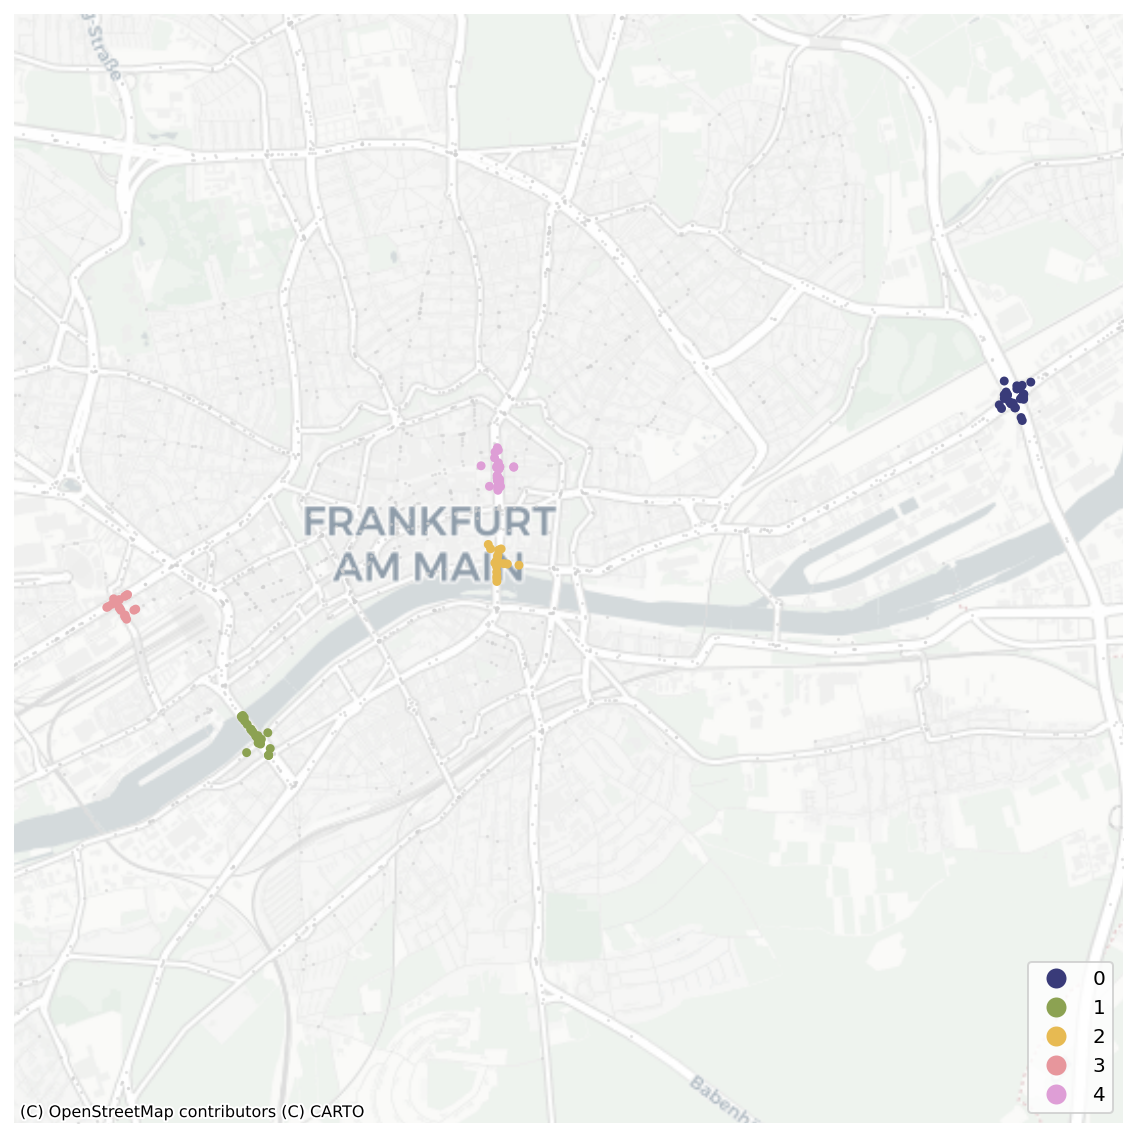

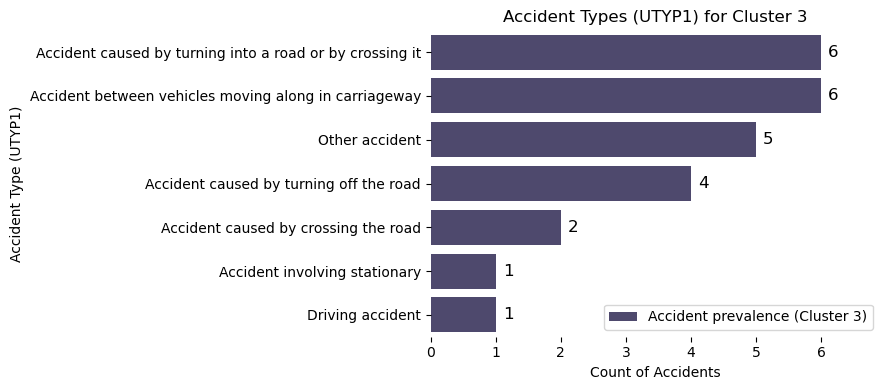

In [59]:
# Night time Clusters
# DBSCAN parameters
CURRENT_EPS = 100
CURRENT_MIN_SAMPLES = 25

# Analysis parameters
COORDINATE_SYSTEM_GPS = "EPSG:4326"
COORDINATE_SYSTEM_WEB = "EPSG:3857"

# Plotting parameters
CLUSTER_TO_PLOT = 3
MAP_PADDING_FACTOR = 0.1
CHART_COLOR = "#494373"

# This placeholder is necessary for the script to run.
if 'Frankfurt' not in locals():
    print("Error: 'Frankfurt' dataframe not loaded. Please load your data first.")
    # YOU MUST REPLACE THIS:
    Frankfurt = pd.DataFrame() 

# Filter for pedestrians
Frankfurt_Night = Frankfurt[Frankfurt['ULICHTVERH'] == 2].copy()

if Frankfurt_Night.empty:
    print("Check Filter")
else:
    # Run DBSCAN
    clusterer = DBSCAN(
        metric='euclidean', 
        eps=CURRENT_EPS,
        min_samples=CURRENT_MIN_SAMPLES
    )
    clusterer.fit(Frankfurt_Night[["LINREFX", "LINREFY"]])
    Frankfurt_Night.loc[:, 'labels'] = clusterer.labels_

    # Cluster Report 
    unique_labels = np.unique(clusterer.labels_)
    num_clusters = len(unique_labels[unique_labels != -1])
    print(f"Found {num_clusters} clusters.")

    # Filter out noise points for all cluster-based analysis
    clusters_df = Frankfurt_Night[Frankfurt_Night['labels'] != -1]

    if clusters_df.empty:
        print("No clusters found (only noise). Map and charts will not be generated.")
    else:
        # Coordinates Report 
        print("Cluster Center Coordinates ")
        cluster_centers = clusters_df.groupby('labels')[['YGCSWGS84', 'XGCSWGS84']].mean()
        cluster_centers.rename(columns={'YGCSWGS84': 'Latitude', 'XGCSWGS84': 'Longitude'}, inplace=True)
        cluster_centers['Google_Maps_Link'] = cluster_centers.apply(
            lambda row: f"https://www.google.com/maps/search/?api=1&query={row['Latitude']},{row['Longitude']}", 
            axis=1
        )
        pd.set_option('display.max_colwidth', None)
        print(cluster_centers)

        # PLOT CLUSTER MAP 
        print("Generating Cluster Map ")
        gdf = gpd.GeoDataFrame(
            Frankfurt_Night, 
            geometry=gpd.points_from_xy(Frankfurt_Night.XGCSWGS84, Frankfurt_Night.YGCSWGS84),
            crs=COORDINATE_SYSTEM_GPS
        )
        gdf_wm = gdf.to_crs(COORDINATE_SYSTEM_WEB)
        fig, ax = plt.subplots(figsize=(10, 10), dpi=144)

        # Plot noise
        gdf_wm[gdf_wm['labels'] == -1].plot(ax=ax, color='lightgrey', markersize=0.5, alpha=0.5, label='Noise')
        
        # Plot clusters
        clusters_wm = gdf_wm[gdf_wm['labels'] != -1]
        clusters_wm.plot(ax=ax, column='labels', categorical=True, markersize=12, legend=True, cmap='tab20b')
        
        # Zoom to clusters
        minx, miny, maxx, maxy = clusters_wm.total_bounds
        center_x, center_y = (minx + maxx) / 2, (miny + maxy) / 2
        data_width, data_height = maxx - minx, maxy - miny
        desired_range = max(data_width, data_height) * (1 + 2 * MAP_PADDING_FACTOR)
        if desired_range == 0: desired_range = 1000 # 1km default
        
        half_range = desired_range / 2
        ax.set_xlim(center_x - half_range, center_x + half_range)
        ax.set_ylim(center_y - half_range, center_y + half_range)

        contextily.add_basemap(ax, source=contextily.providers.CartoDB.Positron)
        ax.set_axis_off()
        plt.show()

        # Plot bar chart for Cluster
        cluster_to_analyze = clusters_df[clusters_df['labels'] == CLUSTER_TO_PLOT]

        if cluster_to_analyze.empty:
            print(f"Error: Cluster {CLUSTER_TO_PLOT} not found or is empty.")
            print(f"Available clusters are: {list(clusters_df['labels'].unique())}")
        else:
            # Create the DataFrame with counts
            plot_df = cluster_to_analyze['UTYP1'].value_counts().reset_index()
            plot_df.columns = ['UTYP1', 'count']
            plot_df['UTYP1'] = plot_df['UTYP1'].astype(str)
            plot_df = plot_df.sort_values("count", ascending=False)

            # Plotting
            fig_bar, ax_bar = plt.subplots(figsize=(9, 4))
            sns.barplot(
                x="count", 
                y="UTYP1", 
                data=plot_df,
                orient='h',
                label=f"Accident prevalence (Cluster {CLUSTER_TO_PLOT})", 
                color=CHART_COLOR,
                ax=ax_bar
            )

            # labels and styling
            ax_bar.bar_label(ax_bar.containers[0], fmt='%.0f', padding=5, fontsize=12)
            max_val = plot_df['count'].max()
            ax_bar.set(xlim=(0, max_val * 1.15))
            ax_bar.set_title(f"Accident Types (UTYP1) for Cluster {CLUSTER_TO_PLOT}")
            ax_bar.set_xlabel("Count of Accidents")
            ax_bar.set_ylabel("Accident Type (UTYP1)")
            ax_bar.legend(loc="lower right", frameon=True)
            sns.despine(ax=ax_bar, left=True, bottom=True)
            plt.grid(False)
            plt.tight_layout()
            plt.show()

And lastly, we are looking at serious injuries.

Found 5 clusters.
Cluster Center Coordinates 
         Latitude  Longitude  \
labels                         
0       50.118604   8.731121   
1       50.107505   8.664689   
2       50.109202   8.694282   
3       50.106929   8.687506   
4       50.139080   8.670190   

                                                                            Google_Maps_Link  
labels                                                                                        
0       https://www.google.com/maps/search/?api=1&query=50.118603891400056,8.731121192840044  
1         https://www.google.com/maps/search/?api=1&query=50.10750546228577,8.66468914233338  
2       https://www.google.com/maps/search/?api=1&query=50.109202231312544,8.694282368562549  
3        https://www.google.com/maps/search/?api=1&query=50.10692851464291,8.687506379214325  
4        https://www.google.com/maps/search/?api=1&query=50.13908031600005,8.670189867071471  
Generating Cluster Map 


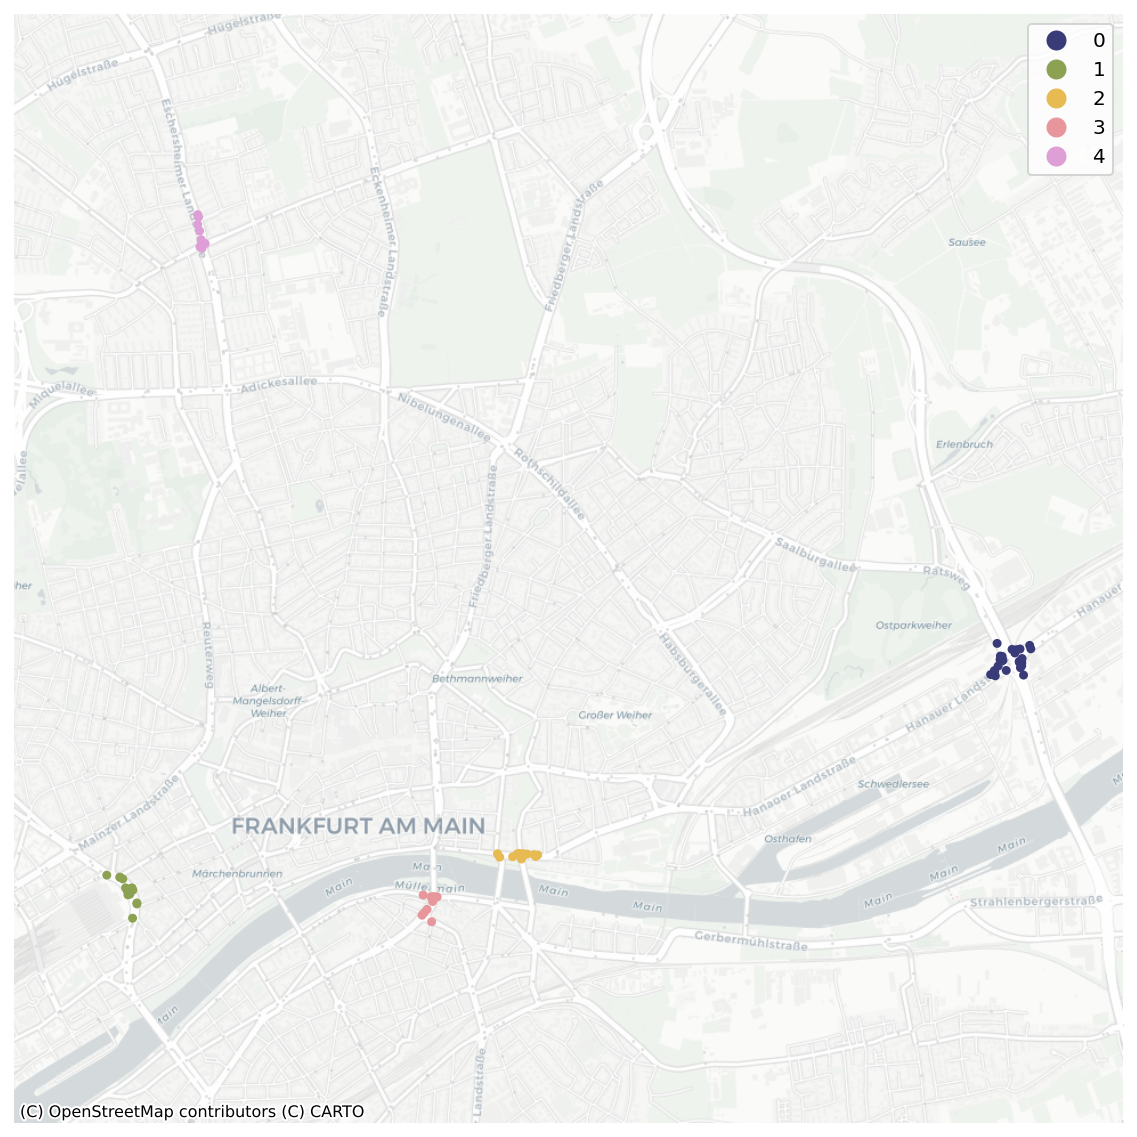

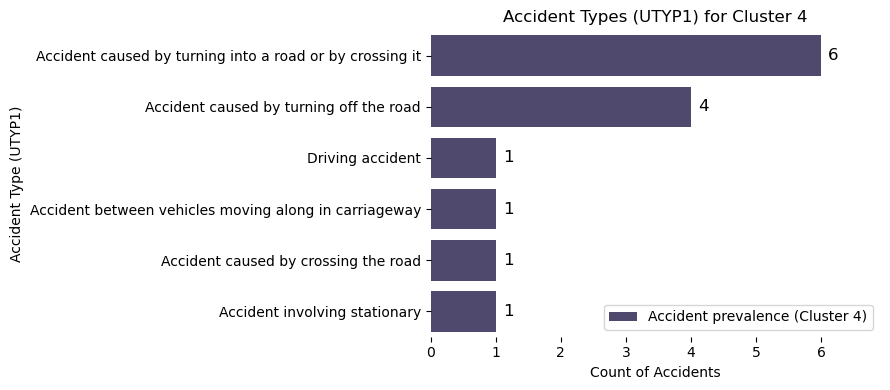

In [60]:
# Serious injury Clusters
# DBSCAN parameters
CURRENT_EPS = 100
CURRENT_MIN_SAMPLES = 13

# Analysis parameters
COORDINATE_SYSTEM_GPS = "EPSG:4326"
COORDINATE_SYSTEM_WEB = "EPSG:3857"

# Plotting parameters
CLUSTER_TO_PLOT = 4
MAP_PADDING_FACTOR = 0.1
CHART_COLOR = "#494373"

# This placeholder is necessary for the script to run.
if 'Frankfurt' not in locals():
    print("Error: 'Frankfurt' dataframe not loaded. Please load your data first.")
    # YOU MUST REPLACE THIS:
    Frankfurt = pd.DataFrame() 

# Filter for pedestrians
Frankfurt_serious = Frankfurt[Frankfurt['UKATEGORIE'].isin([1, 2])].copy()

if Frankfurt_serious.empty:
    print("Check Filter")
else:
    # Run DBSCAN
    clusterer = DBSCAN(
        metric='euclidean', 
        eps=CURRENT_EPS,
        min_samples=CURRENT_MIN_SAMPLES
    )
    clusterer.fit(Frankfurt_serious[["LINREFX", "LINREFY"]])
    Frankfurt_serious.loc[:, 'labels'] = clusterer.labels_

    # Cluster Report 
    unique_labels = np.unique(clusterer.labels_)
    num_clusters = len(unique_labels[unique_labels != -1])
    print(f"Found {num_clusters} clusters.")

    # Filter out noise points for all cluster-based analysis
    clusters_df = Frankfurt_serious[Frankfurt_serious['labels'] != -1]

    if clusters_df.empty:
        print("No clusters found (only noise). Map and charts will not be generated.")
    else:
        # Coordinates Report 
        print("Cluster Center Coordinates ")
        cluster_centers = clusters_df.groupby('labels')[['YGCSWGS84', 'XGCSWGS84']].mean()
        cluster_centers.rename(columns={'YGCSWGS84': 'Latitude', 'XGCSWGS84': 'Longitude'}, inplace=True)
        cluster_centers['Google_Maps_Link'] = cluster_centers.apply(
            lambda row: f"https://www.google.com/maps/search/?api=1&query={row['Latitude']},{row['Longitude']}", 
            axis=1
        )
        pd.set_option('display.max_colwidth', None)
        print(cluster_centers)

        # PLOT CLUSTER MAP 
        print("Generating Cluster Map ")
        gdf = gpd.GeoDataFrame(
            Frankfurt_serious, 
            geometry=gpd.points_from_xy(Frankfurt_serious.XGCSWGS84, Frankfurt_serious.YGCSWGS84),
            crs=COORDINATE_SYSTEM_GPS
        )
        gdf_wm = gdf.to_crs(COORDINATE_SYSTEM_WEB)
        fig, ax = plt.subplots(figsize=(10, 10), dpi=144)

        # Plot noise
        gdf_wm[gdf_wm['labels'] == -1].plot(ax=ax, color='lightgrey', markersize=0.5, alpha=0.5, label='Noise')
        
        # Plot clusters
        clusters_wm = gdf_wm[gdf_wm['labels'] != -1]
        clusters_wm.plot(ax=ax, column='labels', categorical=True, markersize=12, legend=True, cmap='tab20b')
        
        # Zoom to clusters
        minx, miny, maxx, maxy = clusters_wm.total_bounds
        center_x, center_y = (minx + maxx) / 2, (miny + maxy) / 2
        data_width, data_height = maxx - minx, maxy - miny
        desired_range = max(data_width, data_height) * (1 + 2 * MAP_PADDING_FACTOR)
        if desired_range == 0: desired_range = 1000 # 1km default
        
        half_range = desired_range / 2
        ax.set_xlim(center_x - half_range, center_x + half_range)
        ax.set_ylim(center_y - half_range, center_y + half_range)

        contextily.add_basemap(ax, source=contextily.providers.CartoDB.Positron)
        ax.set_axis_off()
        plt.show()

        # Plot bar chart for Cluster
        cluster_to_analyze = clusters_df[clusters_df['labels'] == CLUSTER_TO_PLOT]

        if cluster_to_analyze.empty:
            print(f"Error: Cluster {CLUSTER_TO_PLOT} not found or is empty.")
            print(f"Available clusters are: {list(clusters_df['labels'].unique())}")
        else:
            # Create the DataFrame with counts
            plot_df = cluster_to_analyze['UTYP1'].value_counts().reset_index()
            plot_df.columns = ['UTYP1', 'count']
            plot_df['UTYP1'] = plot_df['UTYP1'].astype(str)
            plot_df = plot_df.sort_values("count", ascending=False)

            # Plotting
            fig_bar, ax_bar = plt.subplots(figsize=(9, 4))
            sns.barplot(
                x="count", 
                y="UTYP1", 
                data=plot_df,
                orient='h',
                label=f"Accident prevalence (Cluster {CLUSTER_TO_PLOT})", 
                color=CHART_COLOR,
                ax=ax_bar
            )

            # labels and styling
            ax_bar.bar_label(ax_bar.containers[0], fmt='%.0f', padding=5, fontsize=12)
            max_val = plot_df['count'].max()
            ax_bar.set(xlim=(0, max_val * 1.15))
            ax_bar.set_title(f"Accident Types (UTYP1) for Cluster {CLUSTER_TO_PLOT}")
            ax_bar.set_xlabel("Count of Accidents")
            ax_bar.set_ylabel("Accident Type (UTYP1)")
            ax_bar.legend(loc="lower right", frameon=True)
            sns.despine(ax=ax_bar, left=True, bottom=True)
            plt.grid(False)
            plt.tight_layout()
            plt.show()

In [47]:
print("--- Accident Counts per UKATEGORIE (for each Cluster) ---")
category_counts = clusters_df.groupby('labels')['UKATEGORIE'].value_counts().sort_index()
print(category_counts)

--- Accident Counts per UKATEGORIE (for each Cluster) ---
labels  UKATEGORIE
0       2             25
1       2             21
2       1              1
        2             15
3       2             14
4       2             14
Name: count, dtype: int64
